In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import json
from myGenerator import DataGenerator

### Carga de datos

In [2]:
train = pd.read_pickle("pan22-authorship-verification-training-dataset/particionesXid/PanTrain.plk")
val = pd.read_pickle("pan22-authorship-verification-training-dataset/particionesXid/PanVal.plk")

In [3]:
def spectraLoader(inputPath: str) -> pd.DataFrame:
    df = pd.DataFrame()
    with open(inputPath, encoding='utf-8') as f:
        for line in f:
            jsonline = json.loads(line)
            lineDf = pd.DataFrame({'id':jsonline['id'], 'spectra':[np.array(jsonline['spectra'])]})
            df = pd.concat([df, lineDf])
    df = df.reset_index(drop=True)

    return df

In [4]:
full_spectra = spectraLoader("pan22-authorship-verification-training-dataset/particionesXid/FullSpectra.jsonl")

In [5]:
def loadLabels(inputPath:str, labelDict:dict) -> dict:
    with open(inputPath, encoding='utf-8') as f:
        for line in f:
            jsonline = json.loads(line)
            labelDict[jsonline['id']] = 1 if jsonline['value'] else 0
        
    return labelDict

In [6]:
labels = dict()
labels = loadLabels('pan22-authorship-verification-training-dataset/particiones/train_truth.jsonl',labels)
labels = loadLabels('pan22-authorship-verification-training-dataset/particiones/val_truth.jsonl',labels)

In [7]:
print("Instances: {}".format((train.shape[0] + val.shape[0])/2))
print("Labels: ",len(labels))

Instances: 16486.0
Labels:  16486


In [8]:
partition = {'train': train.id.unique().tolist(), 'validation': val.id.unique().tolist()}

In [9]:
print("Train: ", len(partition['train']))
print("Validation: ", len(partition['validation']))
print("Total: ", len(partition['train'])+len(partition['validation']))

Train:  15732
Validation:  754
Total:  16486


### Definición de la arquitectura del modelo

In [10]:
# Modelo de red siamesa utilizando una red residual y un perceptron multicapa SIN CAPAS CUSTOM

def setModel():
    x1 = tf.keras.Input(shape=(1200,), name="input_1")
    x2 = tf.keras.Input(shape=(1200,), name="input_2")

    merge = x1-x2

    # MLPNN Classifier
    hidden1 = tf.keras.layers.Dense(600, activation='relu',kernel_regularizer='l2' , name="HiddenLayer1")(merge)
    dropout_layer1 = tf.keras.layers.Dropout(0.4, name="Dropout1")(hidden1)
    hidden2 = tf.keras.layers.Dense(300, activation='relu',kernel_regularizer='l2' , name="HiddenLayer2")(dropout_layer1)
    dropout_layer2 = tf.keras.layers.Dropout(0.4, name="Dropout2")(hidden2)
    output = tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")(dropout_layer2)

    model = tf.keras.Model([x1, x2], output)
    model.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics=["binary_accuracy"])

    return model

In [11]:
model = setModel()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1200)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1200)]       0           []                               
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 1200)         0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 HiddenLayer1 (Dense)           (None, 600)          720600      ['tf.math.subtract[0][0]']   

2022-05-24 14:20:58.003015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 14:20:58.024653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 14:20:58.024786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 14:20:58.025164: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### Entrenamiento del modelo

In [12]:
# Parameters
params = {'dim': (1200,),
            'batch_size': 32,
            'shuffle': True}

In [13]:
# Generators
training_generator = DataGenerator(partition['train'], train, labels, full_spectra, **params)
validation_generator = DataGenerator(partition['validation'], val, labels, full_spectra, **params)

In [14]:
tf.test.gpu_device_name()

2022-05-24 14:20:58.570996: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 14:20:58.571148: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 14:20:58.571226: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 14:20:58.571339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 14:20:58.571420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

'/device:GPU:0'

580 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [15]:
# Train model on dataset
with tf.device('/device:GPU:0'):
    model = setModel()
    # callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    history = model.fit(x=training_generator,
                        validation_data=validation_generator,
                        # callbacks=[callback],
                        # use_multiprocessing=True,
                        # workers=4,
                        epochs=200,
                        verbose=1)
print("Entrnamiento completado")

Epoch 1/200
  5/491 [..............................] - ETA: 20s - loss: 11.7334 - binary_accuracy: 0.5562

2022-05-24 14:20:59.654842: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


491/491 [==============================] - 28s 56ms/step - loss: 1.2586 - binary_accuracy: 0.5332 - val_loss: 0.6949 - val_binary_accuracy: 0.5109
Epoch 2/200
491/491 [==============================] - 27s 55ms/step - loss: 0.6959 - binary_accuracy: 0.5370 - val_loss: 0.6954 - val_binary_accuracy: 0.5326
Epoch 3/200
491/491 [==============================] - 27s 56ms/step - loss: 0.6946 - binary_accuracy: 0.5369 - val_loss: 0.6949 - val_binary_accuracy: 0.5326
Epoch 4/200
491/491 [==============================] - 27s 56ms/step - loss: 0.6935 - binary_accuracy: 0.5421 - val_loss: 0.6949 - val_binary_accuracy: 0.5380
Epoch 5/200
491/491 [==============================] - 27s 55ms/step - loss: 0.6939 - binary_accuracy: 0.5282 - val_loss: 0.6938 - val_binary_accuracy: 0.5326
Epoch 6/200
491/491 [==============================] - 27s 55ms/step - loss: 0.6932 - binary_accuracy: 0.5311 - val_loss: 0.6924 - val_binary_accuracy: 0.5625
Epoch 7/200
491/491 [==============================] - 27s

In [16]:
model.save('models/ClassifierModel-v14')

2022-05-24 15:52:46.879351: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/ClassifierModel-v14/assets


### Resultados del entrenamiento

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

In [18]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [19]:
acc = pd.DataFrame({'accuracy':history.history['binary_accuracy'], 'type':'train'}).reset_index().rename(columns={'index':'epoch'})
acc = pd.concat([acc, pd.DataFrame({'accuracy':history.history['val_binary_accuracy'], 'type':'val'}).reset_index().rename(columns={'index':'epoch'})]).reset_index(drop=True)
loss = pd.DataFrame({'loss':history.history['loss'], 'type':'train'}).reset_index().rename(columns={'index':'epoch'})
loss = pd.concat([loss, pd.DataFrame({'loss':history.history['val_loss'], 'type':'val'}).reset_index().rename(columns={'index':'epoch'})]).reset_index(drop=True)

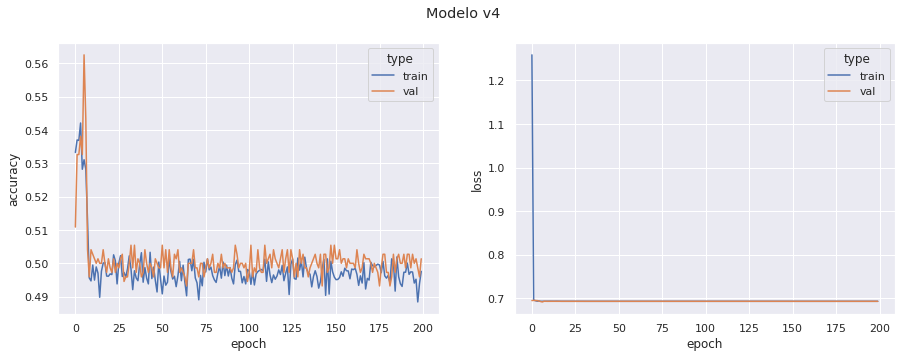

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.lineplot(x='epoch', y='accuracy', data=acc, hue='type', ax=ax[0])
sns.lineplot(x='epoch', y='loss', data=loss, hue='type', ax=ax[1])
fig.suptitle("Modelo v4")
plt.show()

In [21]:
acc.loc[acc.epoch == acc.epoch.max()]

,epoch,accuracy,type
199,199,0.497581,train
399,199,0.501359,val


In [22]:
loss.loc[loss.epoch == loss.epoch.max()]

,epoch,loss,type
199,199,0.693180,train
399,199,0.693144,val


### Evaluación de datos de prueba

In [ ]:
!python PredictionsTest.py -i testinput -o testoutput/v14

In [ ]:
!python pan22_verif_evaluator.py -i testinput -a testoutput/v14 -o testoutput/v14